In [1]:
# importeer libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib
import lifelines


In [2]:
df = pd.read_csv('helpdesk.csv')
df["start_date"] = pd.to_datetime(df["start_date"], format="%Y-%m-%d")
df["end_date"]   = pd.to_datetime(df["end_date"],   format="%Y-%m-%d", errors="coerce")

In [3]:
df['experience_cat']


0       medium
1       medium
2          low
3          low
4       medium
         ...  
8110    medium
8111    medium
8112       low
8113      high
8114    medium
Name: experience_cat, Length: 8115, dtype: object

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_date        8115 non-null   datetime64[ns]
 1   priority          8115 non-null   object        
 2   experience_cat    8115 non-null   object        
 3   team_size         8115 non-null   int64         
 4   budget            8115 non-null   int64         
 5   type              8115 non-null   object        
 6   status            8115 non-null   object        
 7   end_date          6846 non-null   datetime64[ns]
 8   Combinatie_tuple  8115 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 570.7+ KB


In [5]:
df_ibs = pd.DataFrame()

df_ibs = pd.get_dummies(df, columns=['priority', 'experience_cat', 'type'], drop_first=False)
df_ibs["Event"] = df["status"].map({'completed': 1, 'ongoing': 0, 'cancelled': 0})
df_ibs['Censoring'] = df['status'] == 'cancelled'
df_ibs['team_size'] = df['team_size']
df_ibs['budget'] = df['budget']

df_ibs["stop_date"] = df_ibs["end_date"]
cutoff = df_ibs["start_date"].max()  # of een vaste datum, of df_ibs["start_date"].max()

df_ibs.loc[df_ibs["stop_date"].isna(), "stop_date"] = cutoff
df_ibs["Survival_time"] = (df_ibs["stop_date"] - df_ibs["start_date"]).dt.days
df_ibs["HH"] = (df_ibs['experience_cat_high'] & df_ibs['priority_high'])
df_ibs["MH"] = (df_ibs['experience_cat_medium'] & df_ibs['priority_medium'])

df_ibs['experience_cat'] = df['experience_cat']
df_ibs['priority'] = df['priority']
df_ibs['type'] = df['type']



df_ibs[2000:2015]

,start_date,team_size,budget,status,end_date,priority_high,priority_low,priority_medium,experience_cat_high,experience_cat_low,...,type_feature,Event,Censoring,stop_date,Survival_time,HH,MH,experience_cat,priority,type
2000,2025-06-07,10,51400,completed,2025-06-15,False,True,False,False,False,...,False,1,False,2025-06-15,8,False,False,medium,low,bug
2001,2025-06-07,7,62700,completed,2025-07-21,False,True,False,False,True,...,False,1,False,2025-07-21,44,False,False,low,low,bug
2002,2025-06-07,4,47900,completed,2025-06-30,False,False,True,False,True,...,True,1,False,2025-06-30,23,False,False,low,medium,feature
2003,2025-06-07,6,41600,completed,2025-06-20,False,False,True,False,True,...,False,1,False,2025-06-20,13,False,False,low,medium,bug
2004,2025-06-07,7,45900,completed,2025-06-29,False,False,True,False,True,...,True,1,False,2025-06-29,22,False,False,low,medium,feature
2005,2025-06-07,4,35900,completed,2025-06-24,True,False,False,False,False,...,False,1,False,2025-06-24,17,False,False,medium,high,bug
2006,2025-06-07,4,48300,completed,2025-06-29,False,False,True,False,True,...,False,1,False,2025-06-29,22,False,False,low,medium,bug
2007,2025-06-07,7,50300,completed,2025-07-03,True,False,False,False,False,...,True,1,False,2025-07-03,26,False,False,medium,high,feature
2008,2025-06-07,6,41600,completed,2025-07-02,True,False,False,False,True,...,False,1,False,2025-07-02,25,False,False,low,high,bug
2009,2025-06-07,5,79900,completed,2025-07-03,False,False,True,False,True,...,False,1,False,2025-07-03,26,False,False,low,medium,bug


In [6]:
df_ibs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   start_date             8115 non-null   datetime64[ns]
 1   team_size              8115 non-null   int64         
 2   budget                 8115 non-null   int64         
 3   status                 8115 non-null   object        
 4   end_date               6846 non-null   datetime64[ns]
 5   priority_high          8115 non-null   bool          
 6   priority_low           8115 non-null   bool          
 7   priority_medium        8115 non-null   bool          
 8   experience_cat_high    8115 non-null   bool          
 9   experience_cat_low     8115 non-null   bool          
 10  experience_cat_medium  8115 non-null   bool          
 11  type_bug               8115 non-null   bool          
 12  type_chore             8115 non-null   bool          
 13  typ

In [23]:
df_ibs["Combinatie_tuple"] = list(
    zip(df_ibs["experience_cat"], df_ibs["priority"])
)

df["Combinatie_tuple"] = list(
    zip(df["experience_cat"], df["priority"])
)

In [17]:
kmf = lifelines.KaplanMeierFitter()

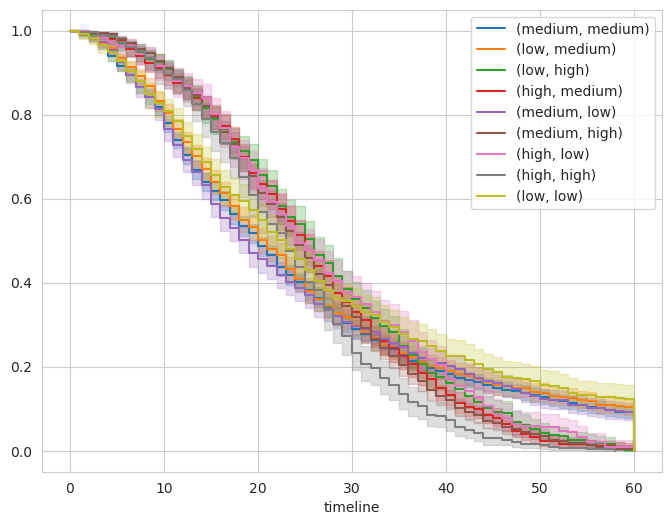

In [18]:
plt.figure(figsize=(8,6))

for level in df_ibs['Combinatie_tuple'].unique():
    mask = df_ibs['Combinatie_tuple'] == level
    kmf.fit(
        durations=df_ibs.loc[mask, 'Survival_time'],
        event_observed=df_ibs.loc[mask, 'Event'],
        label=level
    )
    
    kmf.plot_survival_function()
plt.show()

In [39]:
curves = {}

for level in df_ibs["Combinatie_tuple"].dropna().unique():
    mask = df_ibs["Combinatie_tuple"] == level
    kmf = lifelines.KaplanMeierFitter().fit(
        df_ibs.loc[mask, "Survival_time"],
        event_observed=df_ibs.loc[mask, "Event"]
    )
    curves[level] = kmf.survival_function_.copy()   # kolomnaam is "KM_estimate"
    
def p_opgelost_binnen_curve(sf, t):
    """
    sf: survival_function_ DataFrame (index = tijd)
    t: aantal dagen
    """
    if t <= sf.index.min():
        S_t = 1.0
    elif t >= sf.index.max():
        S_t = float(sf.iloc[-1, 0])
    else:
        S_t = float(sf.loc[sf.index <= t].iloc[-1, 0])
    return 1 - S_t

In [22]:
totaal = len(df_ibs)

resultaten = {}

for tup in df_ibs['Combinatie_tuple'].unique():
    n = len(df_ibs[df_ibs['Combinatie_tuple'] == tup])
    resultaten[tup] = n/totaal
resultaten

{('medium', 'medium'): 0.24707332101047444,
 ('low', 'medium'): 0.14713493530499075,
 ('low', 'high'): 0.07578558225508318,
 ('high', 'medium'): 0.09710412815773259,
 ('medium', 'low'): 0.13012939001848428,
 ('medium', 'high'): 0.12495378927911276,
 ('high', 'low'): 0.049044978434996916,
 ('high', 'high'): 0.05323475046210721,
 ('low', 'low'): 0.07553912507701786}

In [25]:
df

,start_date,priority,experience_cat,team_size,budget,type,status,end_date,Combinatie_tuple
0,2025-04-01,medium,medium,7,43200,bug,completed,2025-05-30,"(medium, medium)"
1,2025-04-01,medium,medium,4,36800,feature,completed,2025-04-23,"(medium, medium)"
2,2025-04-01,medium,low,3,47700,bug,completed,2025-04-29,"(low, medium)"
3,2025-04-01,medium,low,9,37000,chore,completed,2025-05-31,"(low, medium)"
4,2025-04-01,medium,medium,4,58500,chore,completed,2025-04-15,"(medium, medium)"
...,...,...,...,...,...,...,...,...,...
8110,2025-10-31,medium,medium,8,60200,bug,ongoing,NaT,"(medium, medium)"
8111,2025-10-31,high,medium,4,71400,feature,ongoing,NaT,"(medium, high)"
8112,2025-10-31,medium,low,7,41100,bug,ongoing,NaT,"(low, medium)"
8113,2025-10-31,high,high,8,13400,bug,ongoing,NaT,"(high, high)"


In [42]:
einddate = pd.Timestamp("2025-11-30")

VW = 0

for idx, item in df[df["status"] == "ongoing"].iterrows():
    tup = item["Combinatie_tuple"]
    start_date = item["start_date"]
    max_dagen = (einddate - start_date).days
    
    kans_opgelost = p_opgelost_binnen_curve(curves[tup], max_dagen)
    VW+=kans_opgelost
VW

1079.3182299180528

In [43]:
len(df[df["status"] == "ongoing"]) # dus plausiebel

1269

In [50]:
df_november = pd.read_csv("y_hat.csv")

df_november["datum"] = pd.date_range(start="2025-11-01",periods=len(df_november),freq="D")

for tup, p in resultaten.items():
    col = tup
    df_november[col] = df_november["predicted_mean"] * p


df_november.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        30 non-null     int64         
 1   predicted_mean    30 non-null     float64       
 2   datum             30 non-null     datetime64[ns]
 3   (medium, medium)  30 non-null     float64       
 4   (low, medium)     30 non-null     float64       
 5   (low, high)       30 non-null     float64       
 6   (high, medium)    30 non-null     float64       
 7   (medium, low)     30 non-null     float64       
 8   (medium, high)    30 non-null     float64       
 9   (high, low)       30 non-null     float64       
 10  (high, high)      30 non-null     float64       
 11  (low, low)        30 non-null     float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 2.9 KB


In [55]:

tuples = resultaten.keys()
estimate_totaal = 0

for index, row in df_november.iterrows():
    max_dagen = (einddate - row['datum']).days
    for tup in tuples:
        estimate_totaal += row[tup] * p_opgelost_binnen_curve(curves[tup], max_dagen)
estimate_totaal

370.5693780404098

In [57]:
VW+estimate_totaal

1449.8876079584625